## Data-driven approach on the example of the task of routing requests in helpdesk

**Problem** - a lot of manual work on the distribution of applications between teams.

**Possible solution** - transfer control over the process of distribution of applications to the ML-model.

The ML model can make mistakes and incorrectly classify applications, but it should not do this more often than 10% of the time.

We assume that by implementing such a system for distributing applications, we will be able to significantly reduce the burden on people who distribute applications manually.

In [28]:
import pandas as pd
import numpy as np

from sklearn.metrics import f1_score,roc_auc_score,precision_score,classification_report,precision_recall_curve,confusion_matrix

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import itertools

import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv("support_data.csv").drop('Unnamed: 0', 1)
df.head(3)

Title  \
0                               Need Ethernet access   
1  Create new account and share the username and ...   
2                     FW: Myspace Login Issue-- Ania   

                                          Resolution  class  category  
0  Please connect the LAN cable to the red port o...     41         1  
1  Go to URL : accountsetup.com, Enter personal d...     35         0  
2  Go to URL : password.reset.com, Enter you logi...     36         0

Let's look at the class distribution:

In [4]:
df['category'].value_counts()

0    125
1     25
Name: category, dtype: int64

As a field for generating features, we will use Title.

In [5]:
# split the data into train/test
X_train, X_test, y_train, y_test = train_test_split(df, df['category'], random_state=0)

In [13]:
# let's build our simple pipeline, but we need to write a class to select the desired field

class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]

pipeline = Pipeline([
     ('title_selector', FeatureSelector(column='Title')), 
     ('title_tfidf', TfidfVectorizer(stop_words='english', max_features=100)), 
     ('clf', LogisticRegression())
], verbose=True)


In [14]:
# train our pipeline
pipeline.fit(X_train, y_train)

[Pipeline] .... (step 1 of 3) Processing title_selector, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing title_tfidf, total=   0.0s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.0s


Pipeline(steps=[('title_selector', FeatureSelector(column='Title')),
                ('title_tfidf',
                 TfidfVectorizer(max_features=100, stop_words='english')),
                ('clf', LogisticRegression())],
         verbose=True)

In [15]:
pipeline.classes_

array([0, 1])

In [19]:
pipeline.named_steps

{'title_selector': FeatureSelector(column='Title'),
 'title_tfidf': TfidfVectorizer(max_features=100, stop_words='english'),
 'clf': LogisticRegression()}

In [20]:
pipeline['clf']

LogisticRegression()

In [21]:
pipeline[1]

TfidfVectorizer(max_features=100, stop_words='english')

In [22]:
pipeline[1].transform(X_test['Title'])

<38x100 sparse matrix of type '<class 'numpy.float64'>'
	with 94 stored elements in Compressed Sparse Row format>

In [24]:
X_test.head()

Title  \
114   What to do when my computer crashes?   
62   Can a virus damage computer hardware?   
33       How do I delete Internet cookies?   
107               The office does not work   
7                  LAN not working in a VM   

                                            Resolution  class  category  
114   There are many reasons why a computer may jus...     21         0  
62    No. Computer viruses are software code design...     16         0  
33    Microsoft Internet Explorer users can go to '...     15         0  
107  Please check the Power cables are properly plu...     40         0  
7    changed network settings to Bridged and config...     49         1

In [25]:
# our predictions for the test set
preds = pipeline.predict_proba(X_test)
preds

array([[0.94736459, 0.05263541],
       [0.93850977, 0.06149023],
       [0.67795719, 0.32204281],
       [0.77781156, 0.22218844],
       [0.79479752, 0.20520248],
       [0.9257766 , 0.0742234 ],
       [0.90359685, 0.09640315],
       [0.90255709, 0.09744291],
       [0.67795719, 0.32204281],
       [0.8999693 , 0.1000307 ],
       [0.69534304, 0.30465696],
       [0.89685729, 0.10314271],
       [0.91716643, 0.08283357],
       [0.87387622, 0.12612378],
       [0.59762107, 0.40237893],
       [0.69534304, 0.30465696],
       [0.69534304, 0.30465696],
       [0.59062298, 0.40937702],
       [0.94680192, 0.05319808],
       [0.92912296, 0.07087704],
       [0.59762107, 0.40237893],
       [0.92825359, 0.07174641],
       [0.91223305, 0.08776695],
       [0.63489871, 0.36510129],
       [0.52608695, 0.47391305],
       [0.92523101, 0.07476899],
       [0.90197375, 0.09802625],
       [0.75105741, 0.24894259],
       [0.93400496, 0.06599504],
       [0.92721554, 0.07278446],
       [0.

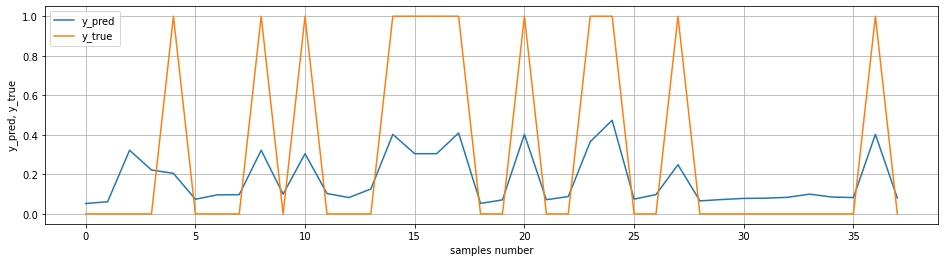

In [26]:
plt.figure(figsize=(16, 4))
plt.grid(True)
plt.xlabel('samples number')
plt.ylabel('y_pred, y_true')

plt.plot(preds[:, 1], label='y_pred')
plt.plot(y_test.values, label='y_true')
plt.legend()
plt.show()

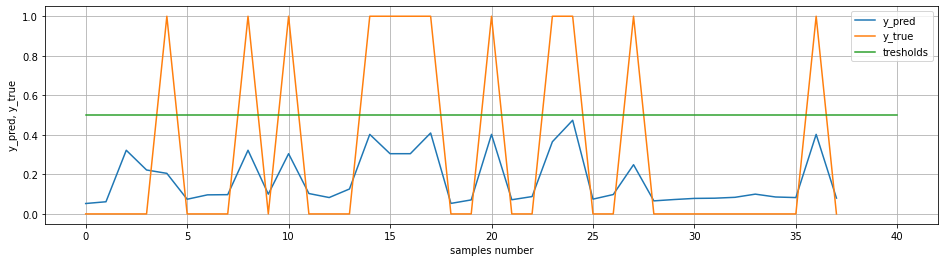

In [27]:
tresholds = 0.5 

plt.figure(figsize=(16,4))
plt.grid(True)
plt.xlabel('samples number')
plt.ylabel('y_pred, y_true')

plt.plot(preds[:, 1], label='y_pred')
plt.plot(y_test.values, label='y_true')
plt.plot([0, 40], [tresholds, tresholds], label='tresholds')

plt.legend()
plt.show()

We also need to move from probabilities to class labels. To do this, you need to choose a threshold, after which we believe that the object can be attributed to class 1 (if the probability is greater than the threshold, we mark the object as class 1, if not, class 0)

In [30]:
precision, recall, thresholds = precision_recall_curve(y_test,preds[:,1]) 

In [31]:
thresholds

array([0.20520248, 0.22218844, 0.24894259, 0.30465696, 0.32204281,
       0.36510129, 0.40237893, 0.40937702, 0.47391305])

In [32]:
precision, recall

(array([0.85714286, 0.84615385, 0.91666667, 0.90909091, 0.875     ,
        1.        , 1.        , 1.        , 1.        , 1.        ]),
 array([1.        , 0.91666667, 0.91666667, 0.83333333, 0.58333333,
        0.5       , 0.41666667, 0.16666667, 0.08333333, 0.        ]))

In [37]:
fscore = (2*precision*recall)/(precision+recall)
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]:.2f}, F-Score={fscore[ix]:.3f}',
      f'Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

Best Threshold=0.21, F-Score=0.923 Precision=0.857, Recall=1.000


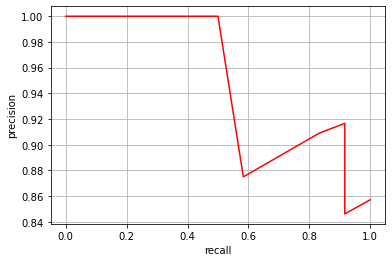

In [38]:
plt.plot(recall, precision, '-r')
plt.grid(True)
plt.xlabel('recall')
plt.ylabel('precision')
plt.show()

In [40]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [41]:
thresholds[ix]

0.2052024803614103

Confusion matrix, without normalization
[[24  2]
 [ 0 12]]


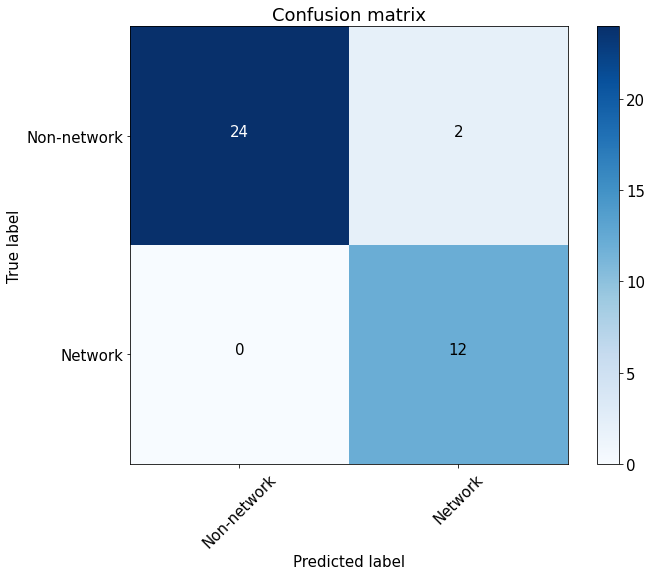

In [42]:
# we already found the "optimal" threshold earlier when we maximized f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds[:, 1] >= thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-network', 'Network'], title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

              precision    recall  f1-score   support

           0       1.00      0.92      0.96        26
           1       0.86      1.00      0.92        12

    accuracy                           0.95        38
   macro avg       0.93      0.96      0.94        38
weighted avg       0.95      0.95      0.95        38



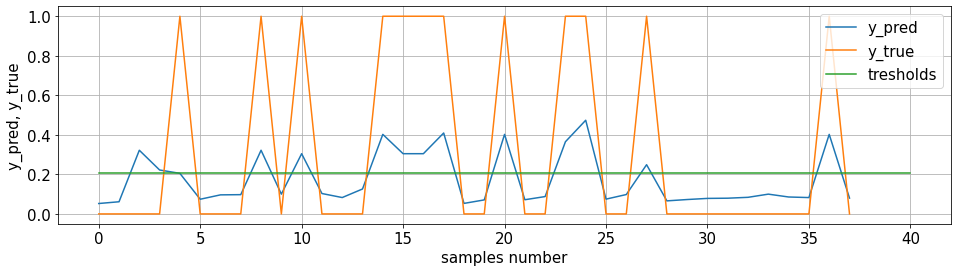

In [43]:
print(classification_report(y_test, preds[:, 1] >= thresholds[ix]))


plt.figure(figsize=(16, 4))
plt.grid(True)
plt.xlabel('samples number')
plt.ylabel('y_pred, y_true')

plt.plot(preds[:, 1], label='y_pred')
plt.plot(y_test.values, label='y_true')
plt.plot([0,40], [thresholds[ix], thresholds[ix]], label='tresholds')

plt.legend()
plt.show()

proportion of incorrectly classified class objects 1 (Network) - $\frac{0}{12} = 0$. This is less than stated 0.1 (in the hypothesis).<br>For class 0 error - $\frac{2}{26} = 0.076$.

The general error is $\frac{2}{24+11+2+1} = 0.05$.